# Layer Combination and Favorability Modeling `geoPFA`: 3D Example from Newberry Volcano, OR
This notebook continues the `geoPFA` tutorial series using the **processed data** prepared in the previous notebook.  

Here, we load the preprocessed configuration and datasets, then use the *Voter–Veto* method to combine layers into geothermal favorability models.  

We’ll cover:
- Loading the processed PFA configuration  
- Reestablishing project paths, reference CRS, data extent, etc.
- Reading in supporting data for plotting and visualization


## 1. Imports and Setup

In [1]:
from pathlib import Path
import numpy as np
import geopandas as gpd

# geoPFA modules
from geoPFA.data_readers import GeospatialDataReaders
from geoPFA.processing import Cleaners
from geoPFA.geopfa3d.layer_combination import VoterVeto
from geoPFA.geopfa3d.plotters import GeospatialDataPlotters
from geoPFA.io import GeospatialDataWriters

# Utility
from rex.utilities.utilities import safe_json_load

### Define Directories and CRS


In [2]:
# Target CRS (UTM Zone 10N for Newberry, Oregon)
target_crs = 26910

# Define key directories relative to this notebook
notebook_dir = Path(__file__).resolve().parent if "__file__" in locals() else Path.cwd()
project_dir = notebook_dir.parent

data_dir = project_dir / "data"
config_dir = project_dir / "config"

print("Notebook directory:", notebook_dir)
print("Data directory:", data_dir)
print("Config directory:", config_dir)


Notebook directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/notebooks
Data directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/data
Config directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/config


### Load the Processed PFA Configuration


In [3]:
pfa_path = config_dir / "newberry_superhot_processed_config.json"
pfa = safe_json_load(str(pfa_path))  # Convert Path → str for safe_json_load
print(f"Loaded PFA configuration from: {pfa_path.name}")

Loaded PFA configuration from: newberry_superhot_processed_config.json


### Load Contextual Data for Plotting
Here we import a well path with associated temperature data for context in plots. `geoPFA` also allows the input of an area outline.

In [4]:
outline_path = data_dir / "supporting_data" / "national_monument_boundary" / "NNVM_bounds.shp"
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded project outline: {outline_path.name}")

In [5]:
well_path_file_path = data_dir / "supporting_data" / "Well Data" / "NWG55-29_TEMP.csv"

well_gdf, well_values = GeospatialDataReaders.read_well_path_csv(
    csv_path=well_path_file_path,
    x_col="X_val",
    y_col="Y_val",
    z_col="Z_val",
    well_name_col="WellID",
    value_col="TEMP_corr",     # now clean + aligned with well_path_values
    source_crs=target_crs,
    to_crs=target_crs,
    z_meas="m-msl",
    target_z_meas="m-msl",
    convert_z_after=False
)

stride = 100
well_gdf_thinned = well_gdf.iloc[::stride].copy()
if well_values is not None:
    well_values_thinned = well_values[::stride]
else:
    well_values_thinned = None

print(f"Loaded well path and thinned to {stride}: {well_path_file_path.name}")

Loaded well path and thinned to 100: NWG55-29_TEMP.csv


## 2. Reading Processed Data and Setting Extent

Now that we’ve loaded the processed configuration, we’ll read the **processed data layers** that were generated in the previous notebook.  
Each dataset corresponds to the `model` output created by functions such as `interpolate_points_3d`, `point_density_3d_projected`, or `distance_from_3d_solids`.

This step ensures that every layer is loaded with consistent metadata (CRS, extent, units) before being combined.

### Read Processed Data

In [6]:
pfa = GeospatialDataReaders.gather_processed_data(data_dir,pfa,crs=target_crs)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: earthquakes
	 component: reservoir
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: ring_faults
		 reading layer: lineaments
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: temperature_model_500m


Each layer is placed back under
`pfa["criteria"][criteria]["components"][component]["layers"][layer]["model"]`,
exactly where the processing functions would have written it in the previous step.

#### Set Extent
To ensure proper alignment, we’ll re-establish the same 3D extent used during processing.
This guarantees that layer combination occurs on a consistent grid.

In [7]:
extent_layer = (
    pfa["criteria"]["geologic"]["components"]["heat"]["layers"]["mt_resistivity_joint_inv"]["model"]
)
extent = Cleaners.get_extent_3d(extent_layer)
extent[2] = np.float64(-6000)  # manually enforce lower z limit for Newberry

print(f"Extent: {extent}")

Extent: [np.float64(624790.875), np.float64(4825350.5), np.float64(-6000.0), np.float64(653145.875), np.float64(4855310.5), np.float64(2379.88427734375)]


The extent should match exactly what was defined in the previous notebook.
If layers were processed elsewhere or on a different grid, they must be re-projected or re-interpolated before combination.

## 3. Transformation and Layer Combination

With all data aligned, we can now combine layers into **component** and **criteria** favorability models using a modified version of the *Voter–Veto* method published in [Ito et al., 2017](https://doi.org/10.1016/j.geothermics.2016.11.004).

The method:
- Normalizes each layer and transforms into marginal favorability layers for each component
- Weights and combines marginal favorability layers to form component favorabiltiy models (e.g., heat, reservoir, insulation)
- Weights and combines component favorability models into a higher-level criteria models (e.g., geologic favorability)
- Optionally normalizes outputs to a defined scale (e.g., 0–5)

The figure below provides context for where we are in the full `geoPFA` framework:
![pfa](figs/pfa_transform_combine.png)

In [8]:
# Combine layers into favorability models
pfa = VoterVeto.do_voter_veto(
    pfa,
    normalize_method="minmax",  # normalize each layer between its min & max
    component_veto=False,       # no veto at the component level
    criteria_veto=True,         # apply veto across components if needed
    normalize=True,             # normalize final favorability model
    norm_to=5,                  # scale favorability to 0-5
)

print("Layer combination complete using the Voter-Veto method.")


density_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
mt_resistivity_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
temperature_model_500m
Transformed a layer using None
Normalized a layer using minmax
earthquakes
Transformed a layer using negate
Normalized a layer using minmax
density_joint_inv
Normalized a layer using minmax
mt_resistivity_joint_inv
Normalized a layer using minmax
earthquakes
Normalized a layer using minmax
ring_faults
Transformed a layer using negate
Normalized a layer using minmax
lineaments
Transformed a layer using negate
Normalized a layer using minmax
density_joint_inv
Normalized a layer using minmax
mt_resistivity_joint_inv
Transformed a layer using negate
Normalized a layer using minmax
earthquakes
Transformed a layer using negate
Normalized a layer using minmax
temperature_model_500m
Transformed a layer using negate
Normalized a layer using minmax
Layer combination complete using the Voter-Veto method.

## 4. Visualizing Favorability Results

With the *Voter–Veto* layer combination complete, we can now visualize the resulting
favorability models in 3D.

Each output is stored under:
- `pfa["criteria"][criteria]["components"][component]["pr_norm"]` - normalized **component** favorability  
- `pfa["criteria"][criteria]["pr_norm"]` - normalized **criteria**-level (overall) favorability  

We’ll plot only the individual component models here. We do not recommend using this model for 3D interpretation due to a lack of visibility into components, given that each component exists in a distinct location in 3D space, stacked over one another. This means that the highest combined geologic favorability may indicate mild favorability for all components in an overlapping location, which is ultimately unfavorable for geothermal development.


### Component Favorability Models - Filtered

Plot individual component favorability layers.

geologic
	heat


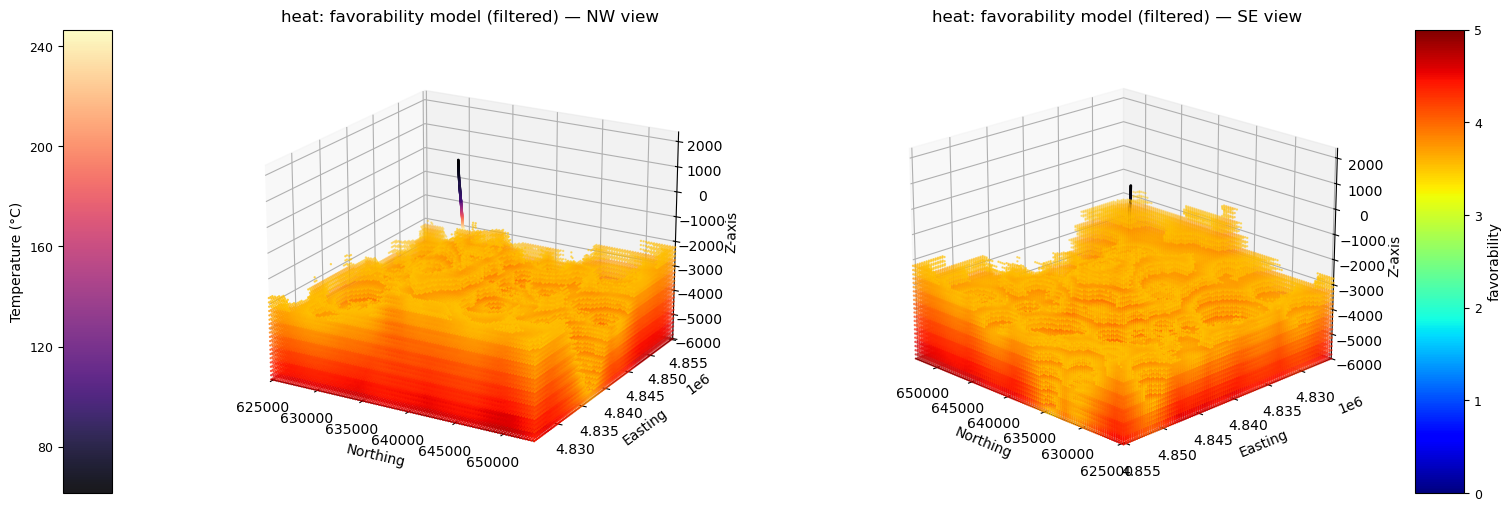

	reservoir


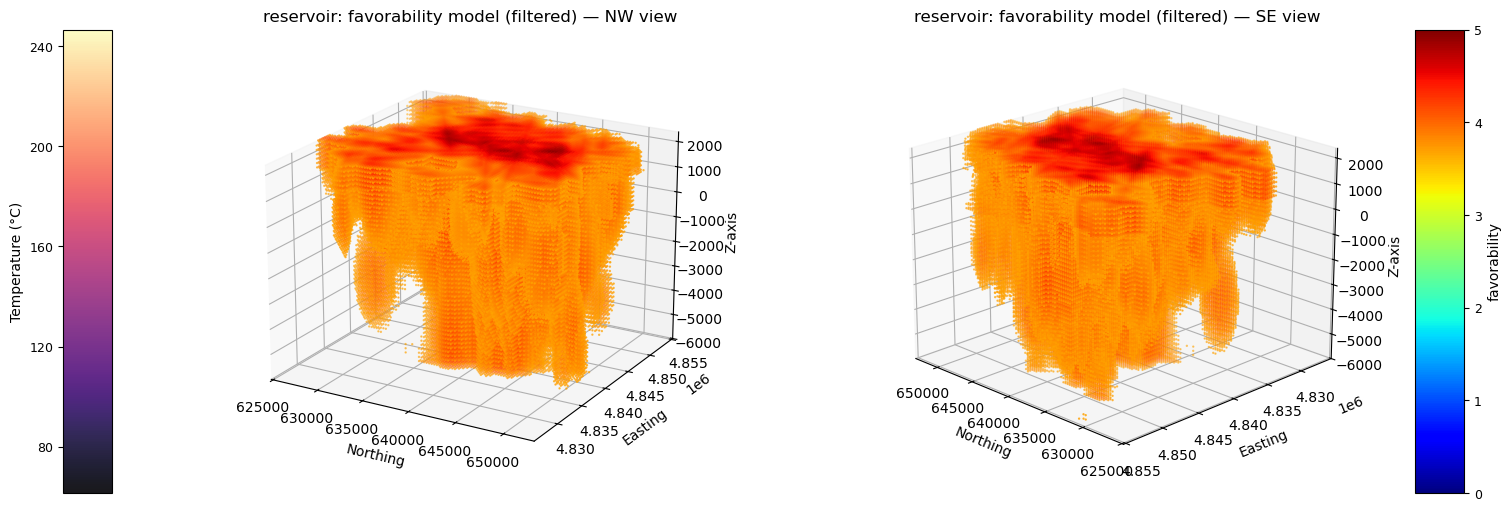

	insulation


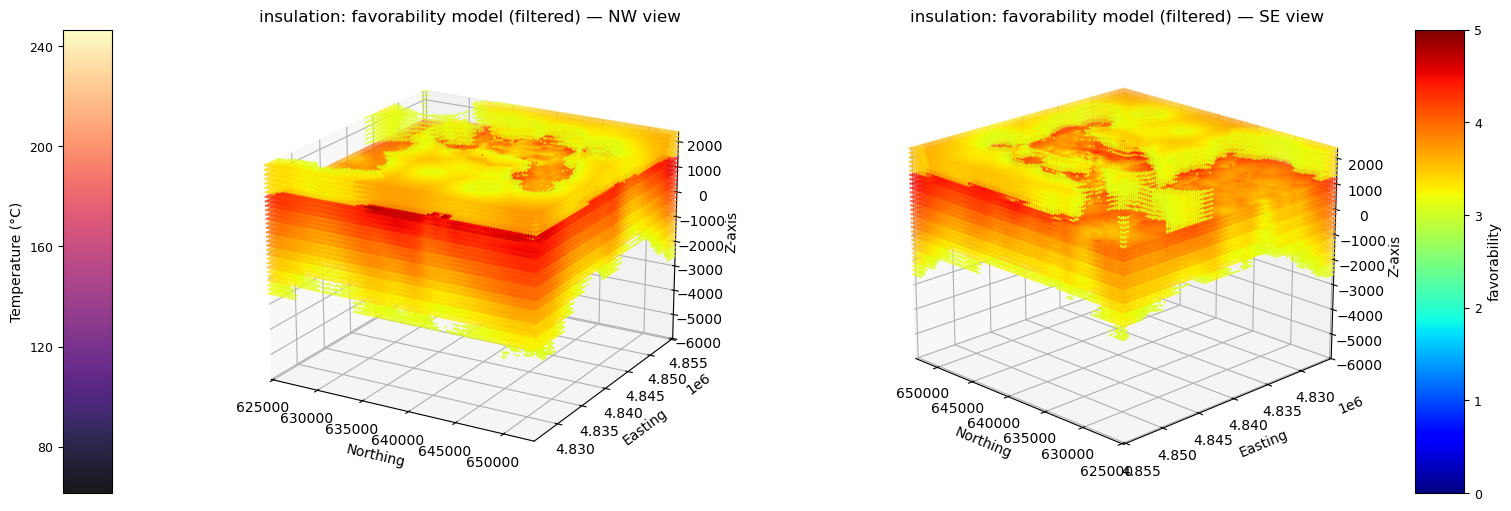

In [14]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model (filtered)"

        thresh = gdf[col].quantile(0.65)
        GeospatialDataPlotters.geo_plot_3d(
            gdf,
            col,
            units,
            title,
            well_path=well_gdf_thinned,
            well_path_values=well_values_thinned,
            extent=extent,
            figsize=(15, 5),
            markersize=0.5,
            filter_threshold=thresh,
        )

Example interpretation:
- "Heat favorability peaks at deeper portions of the domain."
- "reservoir favorability centers nearer the surface, aligning with high earthquake density."
- "Insulation favorability dominates near the top, where density, resitivity, and velocity are high."

### Component Favorability Models — Vertical Slices

Repeat the same component plots as vertical slices to visualize depth trends.

geologic
	heat


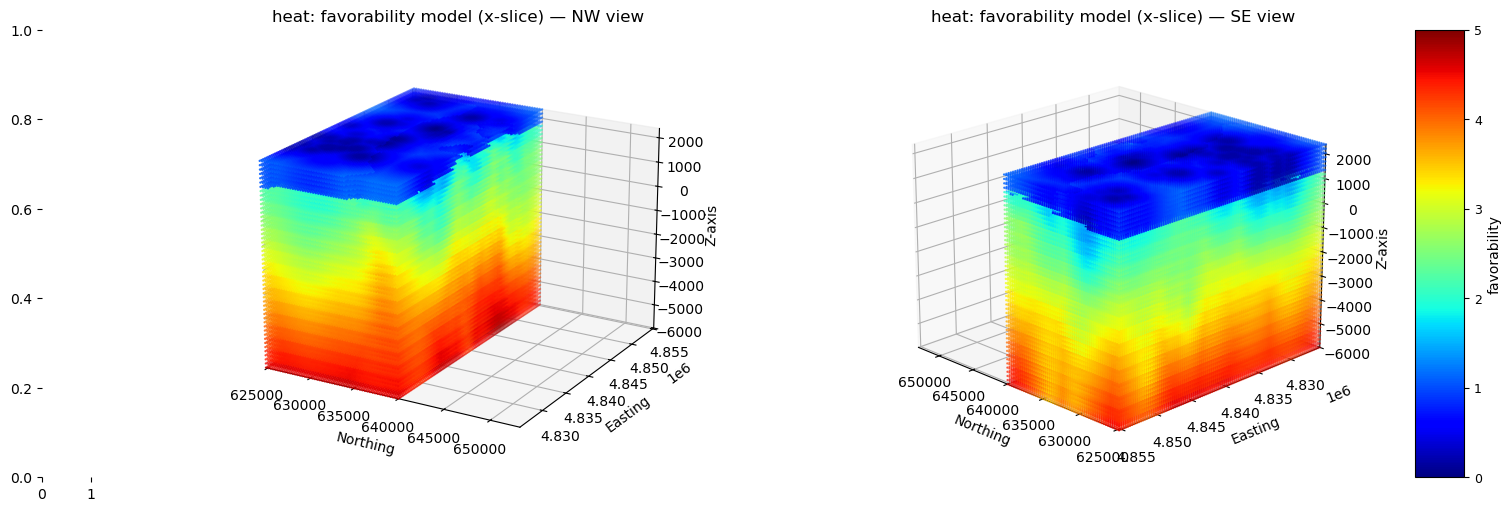

	reservoir


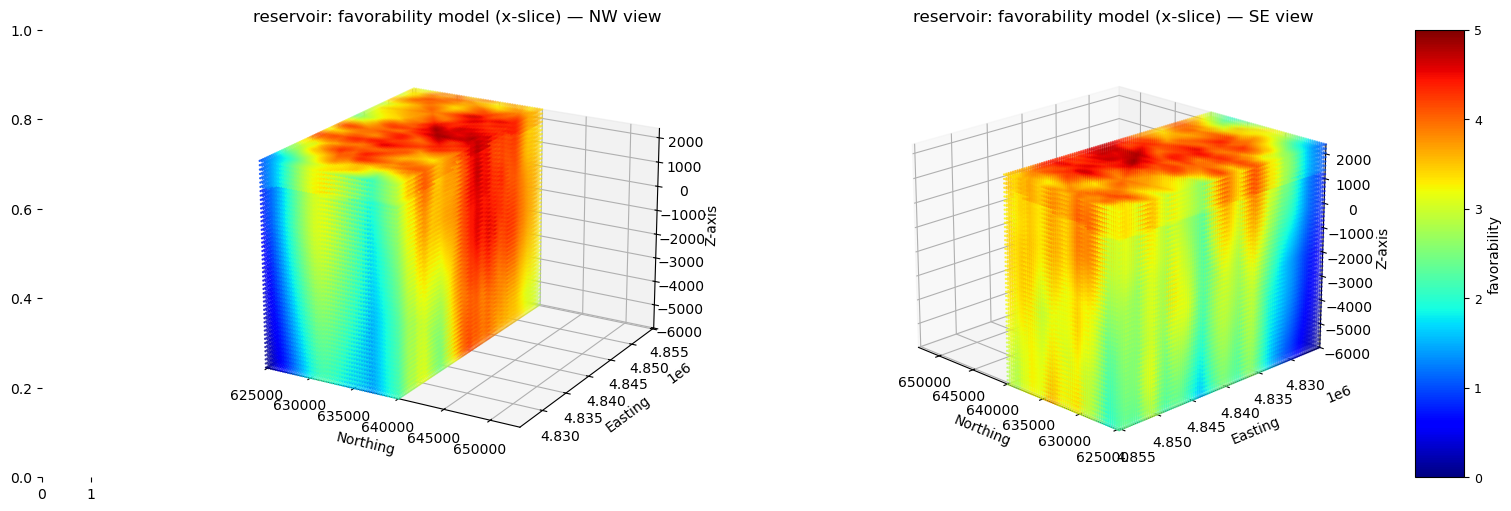

	insulation


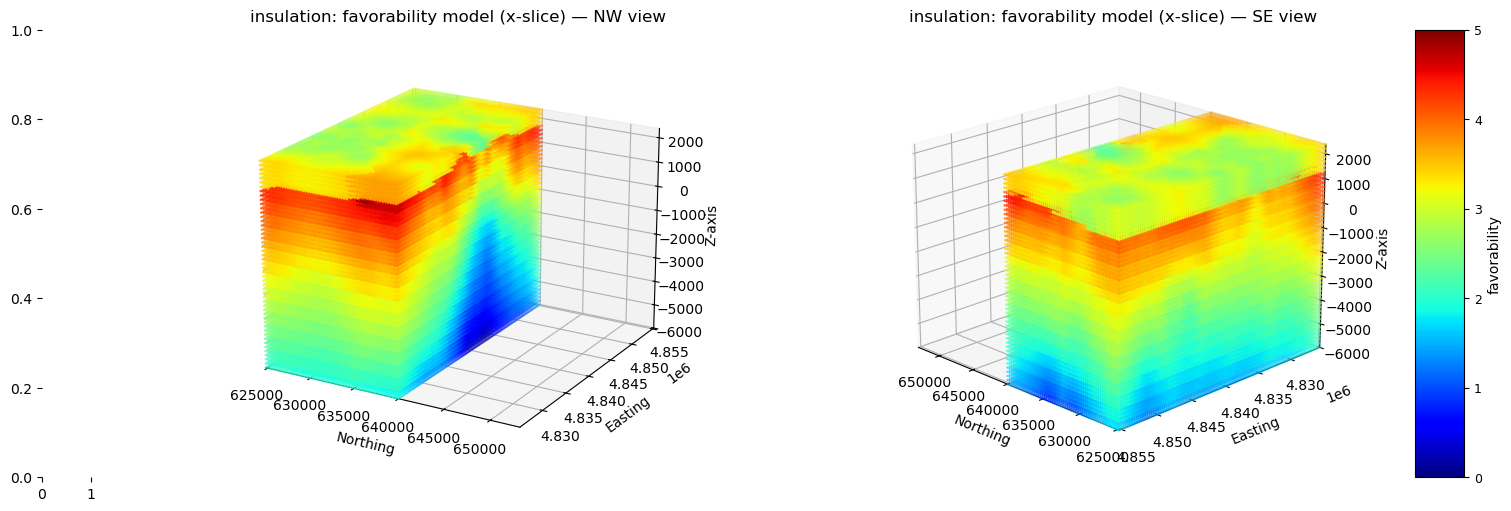

In [10]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")

        gdf = comp_data["pr_norm"].copy()
        col = "favorability"
        units = "favorability"
        title = f"{component}: favorability model (x-slice)"

        GeospatialDataPlotters.geo_plot_3d(
            gdf,
            col,
            units,
            title,
            extent=extent,
            figsize=(15, 5),
            markersize=0.5,
            x_slice=640000,
        )

## 5. Exporting Favorability Models

The final step is to export the combined and component‐level favorability models as shapefiles.  
These outputs can be opened directly in **QGIS**, **ArcGIS**, or other geospatial tools for visualization and further analysis.

Each GeoDataFrame is written to a shapefile using `GeospatialDataWriters.write_shapefile()`,  
which preserves geometry, attributes, and the project CRS.


### Criteria- and Component-Level Models

Export each criteria model (e.g., geologic) and its components (heat, reservoir, insulation).

In [12]:
for criteria, crit_data in pfa["criteria"].items():
    print(criteria)

    # Criteria-level export
    crit_out_dir = output_dir / f"{criteria}_criteria_favorability_models"
    crit_out_dir.mkdir(exist_ok=True)

    gdf = crit_data["pr_norm"]
    crit_fp = crit_out_dir / f"{criteria}_criteria_favorability_model_highT.shp"
    GeospatialDataWriters.write_shapefile(gdf, crit_fp, target_crs)
    print(f"\t✅ Wrote {criteria} criteria model")

    # Component-level exports
    for component, comp_data in crit_data["components"].items():
        print(f"\t{component}")
        comp_out_dir = output_dir / f"{component}_component_favorability_models"
        comp_out_dir.mkdir(exist_ok=True)

        gdf = comp_data["pr_norm"]
        comp_fp = comp_out_dir / f"{component}_component_favorability_model_highT.shp"
        GeospatialDataWriters.write_shapefile(gdf, comp_fp, target_crs)
        print(f"\t\t✅ Wrote {component} component model")

/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


geologic


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


	✅ Wrote geologic criteria model
	heat


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


		✅ Wrote heat component model
	reservoir


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(
/Users/ntaverna/Documents/DEEPEN/geoPFA/geoPFA/io/data_writers.py:60: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_crs(target_crs).to_file(path)


		✅ Wrote reservoir component model
	insulation
		✅ Wrote insulation component model


/usr/local/anaconda3/envs/geopfa/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'favorability' to 'favorabili'
  ogr_write(


### Summary

You now have:
- A combined **geologic criteria favorability model**
  - **Note**: We do not recommend using this model for 3D interpretation due to a lack of visibility into components, given that each component exists in a distinct location in 3D space, stacked over one another. This means that the highest combined geologic favorability may indicate mild favorability for all components in an overlapping location, which is ultimately unfavorable for geothermal development.
- Individual **component favorability models**  

The resulting models can be exported as shapefiles or CSV files to be used for:
- Overlaying favorability with site infrastructure or exclusion zones  
- Cross-checking results against geologic models  
- Sharing results externally in standard GIS formats  

This concludes the example workflow for **import → data processing → layer combination → export**  
using `geoPFA` for the Newberry Volcano play fairway analysis.